# Assignment Week 6 and 7 - Location Planning

In [26]:
import numpy as np
import pandas as pd
import random
import gurobipy as gp
from gurobipy import *
import matplotlib.pyplot as plt

# Model

In [192]:
model = Model("Road inspectors")

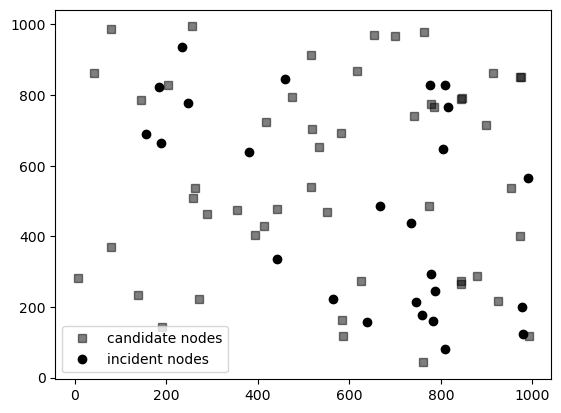

In [193]:
np.random.seed(20)
candidates = np.random.randint(0, 1000, (50, 2))
incidents = np.random.randint(0, 1000, (25, 2))

plt.plot(candidates[:, 0], candidates[:, 1], 'ks', alpha=0.5, label='candidate nodes')
plt.plot(incidents[:, 0], incidents[:, 1], 'ko', label='incident nodes')
plt.legend()

In [216]:
N = np.arange(len(candidates))
K = np.arange(len(incidents))
M = 999999 # Big M
# Parameters
d = np.ones(((len(N), len(K))), dtype=float) * M
for i in range(len(N)):
    for k in range(len(K)):
        d[i, k] = np.sqrt(np.sum((candidates[i, :] - incidents[k, :]) ** 2))

inspector_cap = 50
N_inspectors = 5

In [217]:
pair = [(i, k) for i in N for k in K]
x = model.addVars(pair, vtype=GRB.BINARY, name="x")
c = model.addVars(N, vtype=GRB.BINARY, name="c")

model.Params.IntegralityFocus=0 
model.update()

In [218]:
model.setObjective(quicksum(d[i, k] * x[i, k] * c[i] for i in N for k in K),
                   GRB.MINIMIZE)

In [219]:
model.addConstrs(quicksum(x[i, k] for i in N) == 1 for k in K);

In [220]:
model.addConstrs(quicksum(x[i, k] for k in K) <= inspector_cap * c[i] for i in N);

In [221]:
model.addConstr(quicksum(c[i] for i in N) <= N_inspectors);

In [222]:
model.update()

In [223]:
model.optimize()


Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 228 rows, 3900 columns and 7800 nonzeros
Model fingerprint: 0x134b1e2c
Model has 1250 quadratic objective terms
Variable types: 0 continuous, 3900 integer (3900 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [0e+00, 0e+00]
  QObjective range [3e+01, 2e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+00]

MIP start from previous solve produced solution with objective 3071.93 (0.04s)
Loaded MIP start from previous solve with objective 3071.93

Presolve removed 152 rows and 2600 columns
Presolve time: 0.02s
Presolved: 1326 rows, 2550 columns, 6350 nonzeros
Variable types: 0 continuous, 2550 integer (2550 binary)

Root relaxation: cutoff, 202 iterations, 0.00 seconds (0.00 work unit

In [224]:
# Print selected facilities
inspectors = []

for i in N:
    for k in K:
        if x[i, k].x == 1:
            inspectors.append(i)
inspectors = np.unique(inspectors)
print('Selected inspectors are nodes '+ str(inspectors))

Selected inspectors are nodes [ 5 10 14 20 43]


In [225]:
print(f'Minimum total cost is {model.ObjVal:.2f} km')
print(f'Number of inspectors is {len(inspectors)}')
print(f'Average distance per inspector {model.ObjVal / len(inspectors):.2f} km')

Minimum total cost is 3071.93 km
Number of inspectors is 5
Average distance per inspector 614.39 km


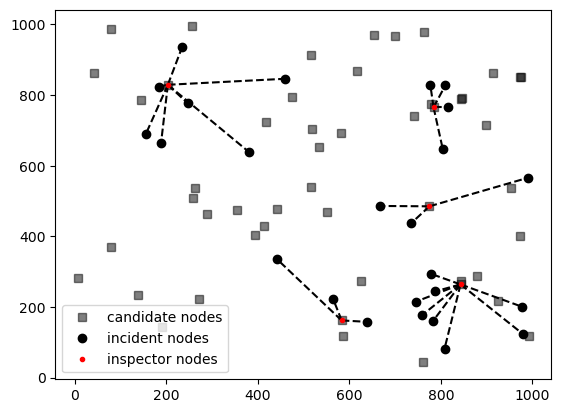

In [226]:
inspector_coordinate = np.zeros((len(inspectors), 2))

for i in range(len(inspectors)):
    inspector_coordinate[i, :] = candidates[inspectors[i], :]
    
for i in N:
    for k in K:
        if x[i, k].x == 1:
            plt.plot((candidates[i, 0], incidents[k, 0]),
                    (candidates[i, 1], incidents[k, 1]),
                    c='black', linestyle='--')

plt.plot(candidates[:, 0], candidates[:, 1], 'ks', alpha=0.5, label='candidate nodes')
plt.plot(incidents[:, 0], incidents[:, 1], 'ko', label='incident nodes')
plt.plot(inspector_coordinate[:, 0], inspector_coordinate[:, 1], 'r.', label='inspector nodes')
plt.legend()